# HIPrim example

In this tutorial we define a primordial power spectrum for the cosmological perturbations and compute the $C_\ell$'s associated to it. Here you are going to learn:

- How to create a new model and registry it in the GObject type system.
- How to use this model together with a $\Lambda$CDM cosmological model to compute the perturbations.

##### The primordial power spectrum:
\begin{equation}
\Delta_k = A_s \left(\frac{k}{k_*}\right)^{n_s-1}\left[1+a^2\cos\left(b \frac{k}{k_*}+c\right)\right],
\end{equation}
where $k_*$ is the pivotal scale and $(A_s,\, n_s,\, a,\, b,\, c)$ are free parameters.

## Loading NumCosmo

The first step is to load both NumCosmo and NumCosmoMath libraries. Here we also load the GObject class that we will use to registry the new class in our GObject type system as well as other modules needed in this example.

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm


# Creating the model

Since python does not give us access to the guts of the GObject system we need to use the *Ncm.ModelBuilder* class to implement a child of *Ncm.Model*.

In [2]:
mb = Ncm.ModelBuilder.new (Nc.HIPrim, "NcHIPrimExample", "A example primordial model")

The line above creates a new *Ncm.ModelBuilder* that will create a child of *Nc.HIPrim* called *Nc.HIPrimExample*. 
The next step is to add parameters to the model, all parameters that will possibly be used in a statistical analysis, see [the expression above](#The-primordial-power-spectrum:). The documentation of the *Ncm.ModelBuilder* class can be found [here](https://numcosmo.github.io/manual/NcmModelBuilder.html). 

In [3]:
mb.add_sparam ("A_s", "As", 0.0, 1.0, 0.1, 0.0, 1.0e-9, Ncm.ParamType.FREE)
mb.add_sparam ("n_s", "ns", 0.5, 1.5, 0.1, 0.0, 0.96,   Ncm.ParamType.FREE)

mb.add_sparam ("a", "a", 0.0,   1.0, 0.01, 0.0,   0.5, Ncm.ParamType.FREE)
mb.add_sparam ("b", "b", 0.0, 1.0e4, 0.10, 0.0, 100.0, Ncm.ParamType.FREE)
mb.add_sparam ("c", "c", 0.0,   6.0, 0.10, 0.0,   0.0, Ncm.ParamType.FREE)

The arguments are the following: (for the C documentation see [here](https://numcosmo.github.io/manual/NcmModelBuilder.html#ncm-model-builder-add-sparam-obj))

1. the (latex) symbol describing the parameter. 
2. the string representing the parameter internally, this same string can be used to access the parameter and change its values.
3. parameter lower-bound.
4. parameter upper-bound.
5. (guess) parameter scale, used by statistical algorithms (e.g., best-fit finders) as a first guess step size. As a rule of thumb it should be at the same order of magnitude as the $1\sigma$ error of the current analysis.
6. absolute tolerance, used when estimating the error on the parameter (useful for parameter that are expected to be exactly zero).
7. parameter default value.
8. Whether this parameter should be treated as a free parameter or fixed (*Ncm.ParamType.FREE* or *Ncm.ParamType.FIXED*) by default.

The code below register the new class in both python and GObject system following the steps:
1. creates the new GType, defining the object in the GObject system.
2. creates a new empty instance of this GType.
3. using this instance we get the python type.
4. Finally we register this python type back in the GObject system.

In [4]:
GNcHIPrimExample = mb.create ()
GObject.new (GNcHIPrimExample)
NcHIPrimExampleBase = GNcHIPrimExample.pytype
GObject.type_register (NcHIPrimExampleBase);

Now we can finally implement in python a class representing the model in hand. We implement a single virtual method of the *Nc.HIPrim* abstract class [*lnSA_powspec_lnk*](https://numcosmo.github.io/manual/NcHIPrim.html#nc-hiprim-lnSA-powspec-lnk). All virtual methods, e.g,  *method_name*, of the abstract classes can be implemented in python by creating a method called *do_method_name* in the derived class in python.

In [5]:
class NcHIPrimExample (NcHIPrimExampleBase):
  def do_lnSA_powspec_lnk (self, lnk):
    lnk0 = self.get_lnk_pivot ()
    lnka = lnk - lnk0
    ka = math.exp (lnka)
    As = self.props.As
    ns = self.props.ns
    a  = self.props.a
    b  = self.props.b
    c  = self.props.c
    a2 = a * a

    return (ns - 1.0) * lnka + math.log (As) + math.log1p (a2 * math.cos (b * ka + c)**2) 

GObject.type_register(NcHIPrimExample);

Some notes about the definition above:
- The base class *Nc.HIPrim* has already a parameter describing pivotal $k_*$, see [here](https://numcosmo.github.io/manual/NcHIPrim.html). Thus, our first step is to get the value of $k_*$. 
- In python the values of the parameters can be accessed using the *props* property, e.g., a parameter created with name As can be accessed via *self.props.As*.
- The virtual method above should implement the function $\ln[\Delta(\ln k)]$ instead of $\Delta_k$.
- Since the class created is a python class, we need to registry it in the GObject type system, which is what we do in the last line of the cell above.

# Initializing the objects

Now that we have our new primordial model we can create the set of objects necessary to compute the $C_\ell$'s. First we need to initialize the NumCosmo library:

In [6]:
Ncm.cfg_init ()

Then, we create an instance of our primordial model object, and print the current (default) values of its parameter.

In [7]:
prim = NcHIPrimExample ()
print ("# Model set to its default values: ", prim.props.As,prim.props.ns, prim.props.a, prim.props.b, prim.props.c)

# Model set to its default values:  1e-09 0.96 0.5 100.0 0.0


Next, we need a CLASS back-end object, but first we create a CLASS precision object. This step is necessary since we have a more complicated primordial power spectrum and for this reason we need a finer simpling of it when computing the other cosmological observables.

In [8]:
cbe_prec = Nc.CBEPrecision.new ()
cbe_prec.props.k_per_decade_primordial = 50.0

cbe = Nc.CBE.prec_new (cbe_prec)

lmax = 2500

Bcbe = Nc.HIPertBoltzmannCBE.full_new (cbe)
Bcbe.set_TT_lmax (lmax)
Bcbe.set_target_Cls (Nc.DataCMBDataType.TT)
Bcbe.set_lensed_Cls (True)


Above we set the number of knots per decade when sampling the primordial power spectrum, see [here](https://numcosmo.github.io/manual/NcCBEPrecision.html) for the documentation of the complete set of parameters. The, we create a class back-end object and the Boltzmann object based on it. Finally, we set the *lmax*, require the computation of the *TT*, $C_\ell$'s and the lens correction.

The next objects are necessary to close our cosmological model:

In [9]:
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("Omegak", 0.0)

reion = Nc.HIReionCamb.new ()

cosmo.add_submodel (reion)
cosmo.add_submodel (prim)

Above we created a *Nc.HICosmoDEXcdm* object as the basic cosmological model with its default values and reparametrized $\Omega_{DE0} \to \Omega_{k0}$ where we set $\Omega_{k0} = 0$. Then, we add both the primordial model and the reionization model as sub-models of cosmo.

Now that we have all the necessary components we can "prepare" the *Bcbe* object using our models:

In [10]:
Bcbe.prepare (cosmo)

Cls_vec = Ncm.Vector.new (lmax + 1)

Bcbe.get_TT_Cls (Cls_vec)

ell = np.array (list (range (2, lmax + 1)))

Cls_a = np.array (Cls_vec.dup_array ()[2:])
Dls_a = ell * (ell + 1.0) * Cls_a


Above we prepare *Bcbe*, create a new vector to hold the $C_\ell$s, and an array representing the values of $\ell$. Then, we define the array *Dls* defined by $D_\ell = \ell(\ell+1)C_\ell$. Below we plot our result:

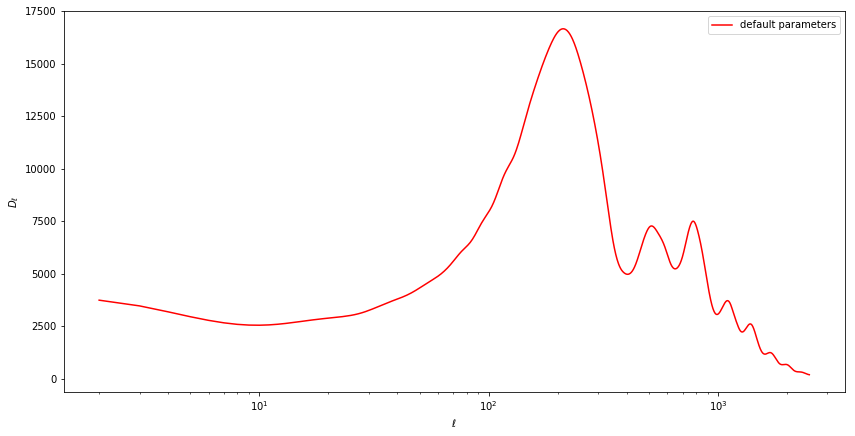

In [11]:
plt.figure (figsize=(14, 7))

plt.xscale('log')
plt.plot (ell, Dls_a, 'r', label="default parameters")

plt.xlabel (r'$\ell$')
plt.ylabel (r'$D_\ell$')
leg = plt.legend (loc = 'best')


To compare with the simple power-law case we just need to set the parameter $a=0$ (see [here](#The-primordial-power-spectrum:)). 

In [12]:
prim.props.a = 0.0

Bcbe.prepare (cosmo)
Bcbe.get_TT_Cls (Cls_vec)

ClsPlaw_a = np.array (Cls_vec.dup_array ()[2:])
DlsPlaw_a = ell * (ell + 1.0) * ClsPlaw_a

And plot both together:

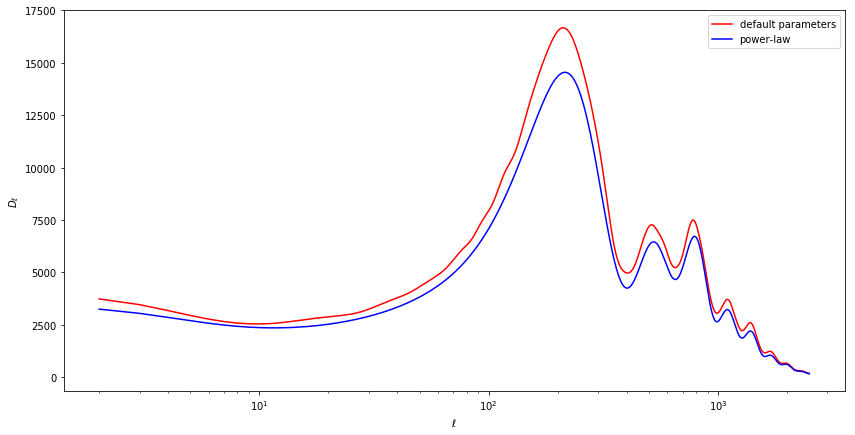

In [13]:
plt.figure (figsize=(14, 7))

plt.xscale('log')
plt.plot (ell, Dls_a,     'r', label="default parameters")
plt.plot (ell, DlsPlaw_a, 'b', label="power-law")

plt.xlabel (r'$\ell$')
plt.ylabel (r'$D_\ell$')
leg = plt.legend (loc = 'best')
